# simulated pump probe for testing ridge, constrained, or more advanced regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import sympy
import sys

In [2]:
sys.path.append('/home/mouth_breather/Desktop/git_version_controlled/symfit')

In [3]:
import symfit

In [4]:
symfit.__file__

'/home/mouth_breather/Desktop/git_version_controlled/symfit/symfit/__init__.py'

In [5]:
sympy.__version__

'1.1.1'

## making simulated data

In [6]:
def y(t,a,w,phi,tau):
    return 50+np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


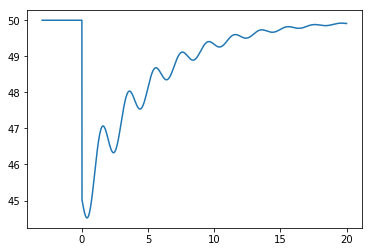

In [7]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [26]:
t_sim     =  np.random.rand(4*len(t))*23-3
e_sim     =  np.random.normal(916,3,len(t_sim))
e_noisy   =  e_sim + np.random.normal(0,1,len(t_sim))
y_sim     =  y(t_sim,1,np.pi,3.1,5) #+np.random.normal(0,1,len(t_sim))
IFEE_sim  =  np.random.rand(len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_noisy)**2/4**2)+np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim *10* (1+(e_sim-895)*10.0) +np.random.normal(0,0.8,len(t_sim))**2

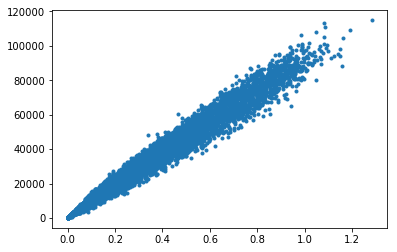

In [27]:
plt.plot(I0_sim,I_sim,'.')

/home/mouth_breather/anaconda3/envs/sympy_v1.1.1/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/mouth_breather/anaconda3/envs/sympy_v1.1.1/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


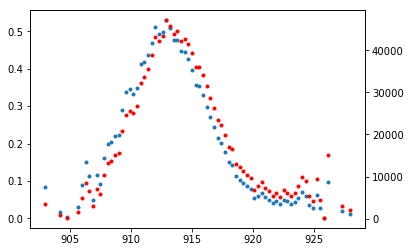

In [28]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')

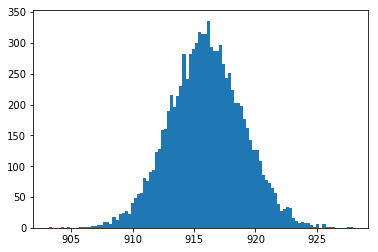

In [29]:
dummy_hist = plt.hist(e_sim,bins=100)

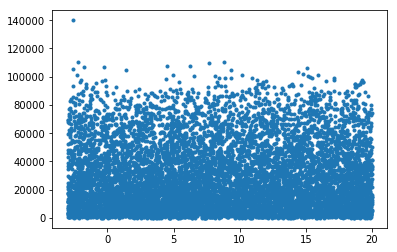

In [18]:
plt.plot(t_sim,I_sim,'.')
plt.show()

## global using symfit

### symfit example

In [39]:
xdata = np.arange(8,21,0.2)
ydata = 3.1* np.e**(-(xdata - 15)**2/(2 * 2**2))
ydata += np.random.rand(len(ydata))

In [40]:
print(xdata)
print(ydata)

[ 8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6
 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4
 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2
 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.
 19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8]
[0.22444792 0.40825302 0.14143446 0.25874252 0.91310184 0.81529434
 0.84155192 0.29722223 0.40171081 0.9910766  0.83795746 0.28348711
 1.00360971 0.7765244  1.24747973 0.67206395 1.17014754 0.82434515
 1.65414576 1.57919836 1.69212172 1.61841673 2.02565055 2.4773591
 2.57285129 2.71448487 2.21330858 2.50920926 3.32756999 2.67304564
 3.51812607 3.43773692 3.96235093 3.69451748 3.28645878 3.4910633
 4.02877712 3.480281   3.23176103 3.47164382 2.7763198  2.72705775
 2.55190641 2.79617694 2.90759596 2.09068793 2.6103939  2.09606464
 2.1644762  2.02248044 1.51566876 1.73687712 0.90813562 1.26997115
 0.89163154 0.99392366 0.53399633 1.22972613 0.79270085 1.02340916
 0

In [41]:
A = symfit.Parameter(name='A',value=4)
sig = symfit.Parameter(name='sig',value=4)
x0 = symfit.Parameter(name='x0',value=15)
x, y = symfit.variables('x, y')


# Gaussian distrubution
model =symfit.Model({y: A * symfit.exp(-(x0 - x)**2/(2 * sig**2))})

In [42]:
fit = symfit.Fit(model, x=xdata, y=ydata)
fit_result = fit.execute()

In [43]:
fit_result.params

OrderedDict([('A', 3.4282554739626403),
             ('sig', 2.618416926205739),
             ('x0', 14.932204019106251)])

In [44]:
y_predict = model(x=xdata, **fit_result.params)

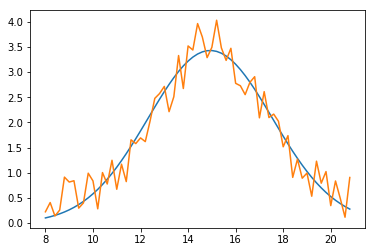

In [48]:
plt.plot(xdata,y_predict.y)
plt.plot(xdata,ydata)
#plt.plot(y,xdata)
plt.show()

In [52]:
t_bins = np.arange(-3,20,0.05)

In [67]:
energy  = symfit.Variable('energy')
I0      = symfit.Variable('I0')
I      = symfit.Variable('I')
offset  = symfit.Parameter(name='offset',value=0)
IvsI0_E = symfit.Parameter(name='IvsI0_E',value=0)
IvsI0   = [symfit.Parameter(name='bin'+str(i),value=45) for i in range(len(t_bins))]

### symfit applied to non global case

In [69]:
#I_sim = I0_sim*y_sim *10* (1+(e_sim-895)/50.0) +np.random.normal(0,0.8,len(t_sim))**2
model   = symfit.Model({I:IvsI0[0]*I0*(1+IvsI0_E*energy) +offset})

In [72]:
fit = symfit.Fit(model,I0=I0_sim,energy=e_sim,I=I_sim)

In [73]:
fit_result = fit.execute()

In [74]:
fit_result.params

OrderedDict([('IvsI0_E', 0.12534666263839173),
             ('bin0', 5.799638459517303),
             ('offset', 3.8206949659264846)])

In [75]:
I_predict = model(I0=I0_sim,energy=e_sim, **fit_result.params)

In [78]:
I_predict.I

array([428.21692166, 194.64843227, 117.04060496, ..., 171.44565716,
       228.53588307,  11.16449809])

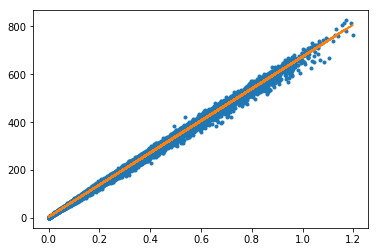

In [80]:
plt.plot(I0_sim,I_sim,'.')
plt.plot(I0_sim,I_predict.I)
#plt.plot(y,xdata)
plt.show()

## standard bin by bin regression

In [19]:
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

residuals = []

I_sim_size = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask]-np.mean(I0_sim[my_mask]),(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    #X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(I0_sim[my_mask])*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    
    residuals.append(list((I_sim[my_mask]-np.dot(X.transpose(),np.array([beta]).transpose())[:,0])))
    I_sim_size = I_sim_size+I_sim[my_mask].shape[0]
    my_pump_probe.append(beta)

In [20]:
my_pump_probe = np.array(my_pump_probe)

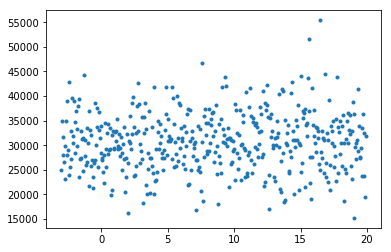

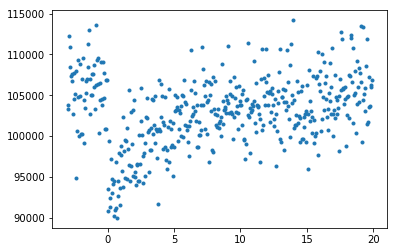

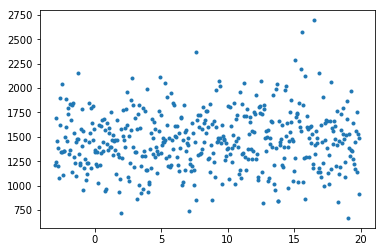

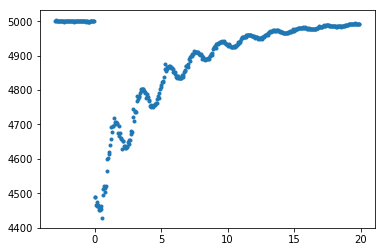

In [21]:
for i in range(X.shape[0]):
    plt.plot(t_bins[:-1],my_pump_probe[:,i],'.')
    plt.show()

## ridge regression

### making big matrix for linearized system


In [25]:
#make giant matrix
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

big_X = np.zeros([I_sim.shape[0],t_bins.shape[0]*4])
big_Y = np.zeros([I_sim.shape[0],t_bins.shape[0]])

my_col = 0
my_row = 0

my_ycol = 0
my_yrow = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = (np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])).transpose()
    Y = I_sim[my_mask]
    
    big_X[my_row:my_row+X.shape[0],my_col:my_col + X.shape[1]] = X
    big_Y[my_yrow:my_yrow+Y.shape[0],my_ycol] = Y
    
    my_col = my_col + X.shape[1]
    my_row = my_row + X.shape[0]
    
    my_ycol = my_ycol + 1
    my_yrow = my_yrow + Y.shape[0]

    
    #beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    #my_pump_probe.append(beta)

In [26]:
pseudo_inv = np.linalg.pinv(big_X)

## diagonal beta

In [27]:
beta = np.dot(pseudo_inv,big_Y)

In [28]:
beta.shape

(1840, 460)

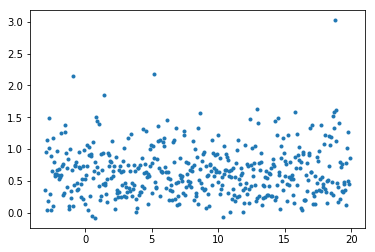

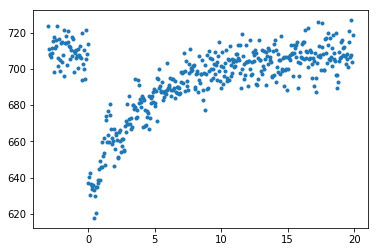

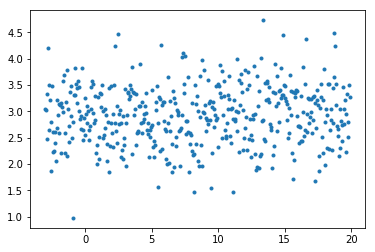

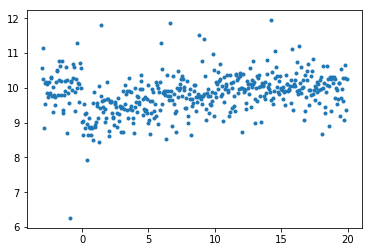

In [29]:
for i in range(4):
    plt.plot(t_bins[:-1],np.diag(beta[i::X.shape[1]][:-1]),'.')
    plt.show()

In [30]:
#now need to implement the tikhonov matrix to constrain standard dev of beta parameters that aren't pump probe
#related and use cross validation to tune them.

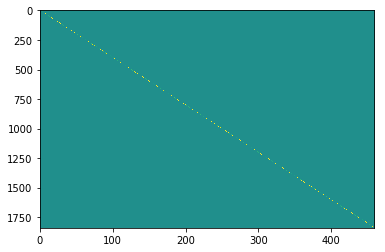

In [31]:
plt.imshow(beta,aspect='auto',clim=(-10,10))

In [32]:
#make ridge kernel
print(beta.shape)
print(big_Y.shape)
print(big_X.shape)

(1840, 460)
(9200, 460)
(9200, 1840)


In [33]:
gamma = 1*(+)

regularization_term = np.dot(np.linalg.inv(np.dot(gamma.transpose(),gamma)),big_X.transpose())


beta = np.dot(pseudo_inv,big_Y) + 

SyntaxError: invalid syntax (<ipython-input-33-01af5d75b94e>, line 1)